### PUBG Finish Placement Prediction
#### Can you predict the battle royale finish of PUBG Players?

Battle Royale-style video games have taken the world by storm. 100 players are dropped onto an island empty-handed and must explore, scavenge, and eliminate other players until only one is left standing, all while the play zone continues to shrink.

PlayerUnknown's BattleGrounds (PUBG) has enjoyed massive popularity. With over 50 million copies sold, it's the fifth best selling game of all time, and has millions of active monthly players.

The team at PUBG has made official game data available for the public to explore and scavenge outside of "The Blue Circle." This competition is not an official or affiliated PUBG site - Kaggle collected data made possible through the PUBG Developer API.

You are given over 65,000 games' worth of anonymized player data, split into training and testing sets, and asked to predict final placement from final in-game stats and initial player ratings.

What's the best strategy to win in PUBG? Should you sit in one spot and hide your way into victory, or do you need to be the top shot? Let's let the data do the talking!

<img src="pubg.jpg">

### Data Description

In a PUBG game, up to 100 players start in each match (matchId). Players can be on teams (groupId) which get ranked at the end of the game (winPlacePerc) based on how many other teams are still alive when they are eliminated. In game, players can pick up different munitions, revive downed-but-not-out (knocked) teammates, drive vehicles, swim, run, shoot, and experience all of the consequences -- such as falling too far or running themselves over and eliminating themselves.

You are provided with a large number of anonymized PUBG game stats, formatted so that each row contains one player's post-game stats. The data comes from matches of all types: solos, duos, squads, and custom; there is no guarantee of there being 100 players per match, nor at most 4 player per group.

You must create a model which predicts players' finishing placement based on their final stats, on a scale from 1 (first place) to 0 (last place)

Data fields:
*   DBNOs - Number of enemy players knocked.
*   assists - Number of enemy players this player damaged that were killed by teammates.
*	boosts - Number of boost items used.
*	damageDealt - Total damage dealt. Note: Self inflicted damage is subtracted.
*	headshotKills - Number of enemy players killed with headshots.
*	heals - Number of healing items used.
*	Id - Player’s Id
*	killPlace - Ranking in match of number of enemy players killed.
*	killPoints - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.
*	killStreaks - Max number of enemy players killed in a short amount of time.
*	kills - Number of enemy players killed.
*	longestKill - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.
*	matchDuration - Duration of match in seconds.
*	matchId - ID to identify match. There are no matches that are in both the training and testing set.
*	matchType - String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.
*	rankPoints - Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.
*	revives - Number of times this player revived teammates.
*	rideDistance - Total distance traveled in vehicles measured in meters.
*	roadKills - Number of kills while in a vehicle.
*	swimDistance - Total distance traveled by swimming measured in meters.
*	teamKills - Number of times this player killed a teammate.
*	vehicleDestroys - Number of vehicles destroyed.
*	walkDistance - Total distance traveled on foot measured in meters.
*	weaponsAcquired - Number of weapons picked up.
*	winPoints - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.
*	groupId - ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.
*	numGroups - Number of groups we have data for in the match.
*	maxPlace - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
*	winPlacePerc - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match


### Import libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, activations
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


### Exploratory data analysis

In [11]:
df=pd.read_csv('pubg.csv')

In [12]:
df.shape

(4446966, 29)

In [13]:
df.head(2)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.8,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.0,5,0,0.6400


In [14]:
df.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc'],
      dtype='object')

In [15]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
Id                 4446966 non-null object
groupId            4446966 non-null object
matchId            4446966 non-null object
assists            4446966 non-null int64
boosts             4446966 non-null int64
damageDealt        4446966 non-null float64
DBNOs              4446966 non-null int64
headshotKills      4446966 non-null int64
heals              4446966 non-null int64
killPlace          4446966 non-null int64
killPoints         4446966 non-null int64
kills              4446966 non-null int64
killStreaks        4446966 non-null int64
longestKill        4446966 non-null float64
matchDuration      4446966 non-null int64
matchType          4446966 non-null object
maxPlace           4446966 non-null int64
numGroups          4446966 non-null int64
rankPoints         4446966 non-null int64
revives            4446966 non-null int64
rideDistance       4446966 non-null flo

In [16]:
df.describe()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
count,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,...,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446965e+06
mean,2.338149e-01,1.106908e+00,1.307171e+02,6.578755e-01,2.268196e-01,1.370147e+00,4.759935e+01,5.050060e+02,9.247833e-01,5.439551e-01,...,1.646590e-01,6.061157e+02,3.496091e-03,4.509322e+00,2.386841e-02,7.918208e-03,1.154218e+03,3.660488e+00,6.064601e+02,4.728216e-01
std,5.885731e-01,1.715794e+00,1.707806e+02,1.145743e+00,6.021553e-01,2.679982e+00,2.746294e+01,6.275049e+02,1.558445e+00,7.109721e-01,...,4.721671e-01,1.498344e+03,7.337297e-02,3.050220e+01,1.673935e-01,9.261157e-02,1.183497e+03,2.456544e+00,7.397004e+02,3.074050e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.551000e+02,2.000000e+00,0.000000e+00,2.000000e-01
50%,0.000000e+00,0.000000e+00,8.424000e+01,0.000000e+00,0.000000e+00,0.000000e+00,4.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.856000e+02,3.000000e+00,0.000000e+00,4.583000e-01
75%,0.000000e+00,2.000000e+00,1.860000e+02,1.000000e+00,0.000000e+00,2.000000e+00,7.100000e+01,1.172000e+03,1.000000e+00,1.000000e+00,...,0.000000e+00,1.909750e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.976000e+03,5.000000e+00,1.495000e+03,7.407000e-01
max,2.200000e+01,3.300000e+01,6.616000e+03,5.300000e+01,6.400000e+01,8.000000e+01,1.010000e+02,2.170000e+03,7.200000e+01,2.000000e+01,...,3.900000e+01,4.071000e+04,1.800000e+01,3.823000e+03,1.200000e+01,5.000000e+00,2.578000e+04,2.360000e+02,2.013000e+03,1.000000e+00


In [8]:
#Sampling due to memory limitation
df=df.sample(frac=0.01)

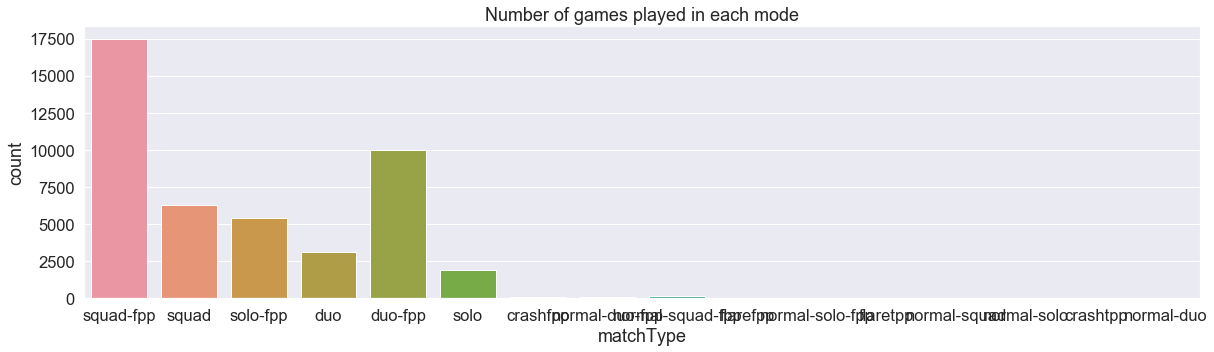

In [9]:
fig,ax=plt.subplots(figsize=(20,5))
ax.set_title('Number of games played in each mode')
sns.countplot(df['matchType'])

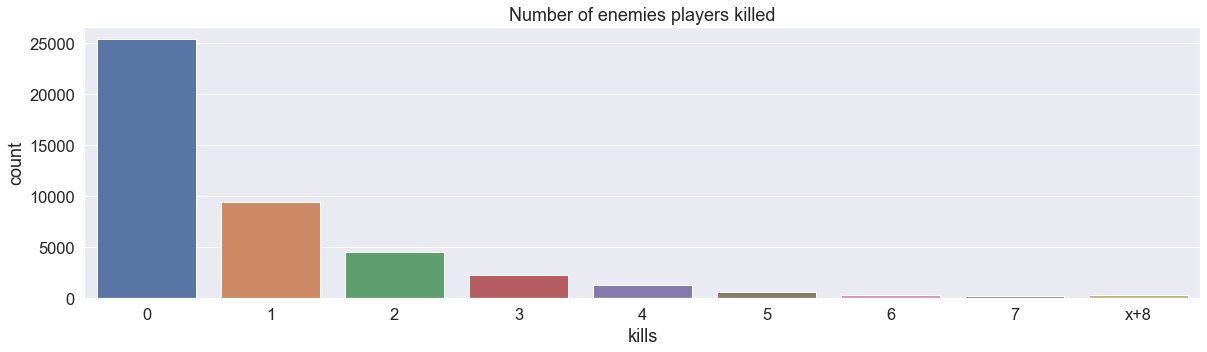

In [10]:
copy_df=df.copy()
kills_class=copy_df['kills'].apply(lambda x: 'x+8' if x>=8 else str(x))
fig,ax=plt.subplots(figsize=(20,5))
ax.set_title('Number of enemies players killed')
sns.countplot(kills_class.sort_values())

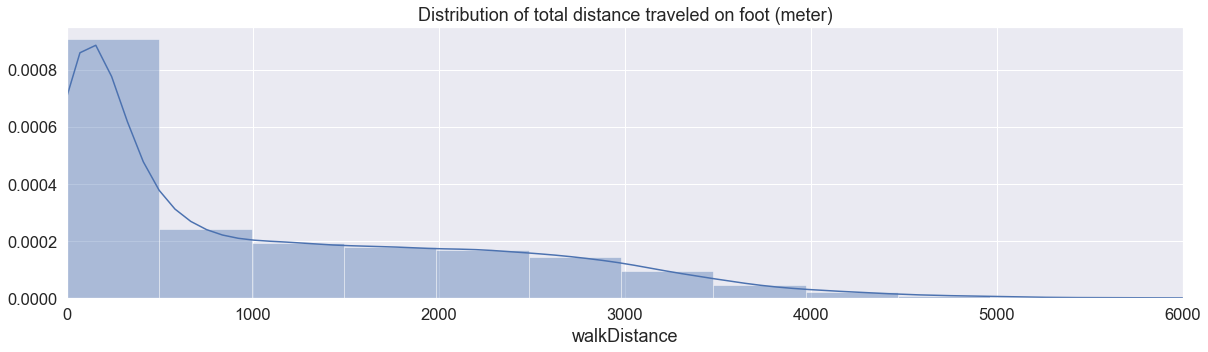

In [11]:
fig,ax=plt.subplots(figsize=(20,5))
ax.set_title('Distribution of total distance traveled on foot (meter)')
ax.set_xlim(0,6000)
sns.distplot(df['walkDistance'],bins=20)

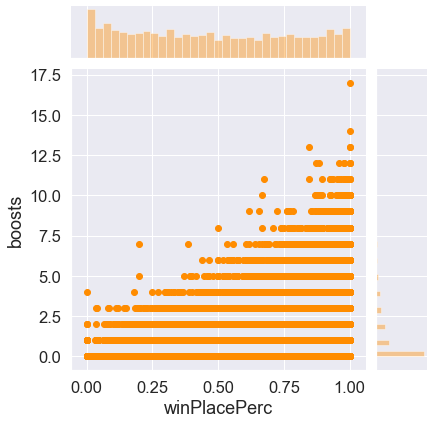

In [12]:
sns.jointplot(df['winPlacePerc'],df['boosts'],color='darkorange')

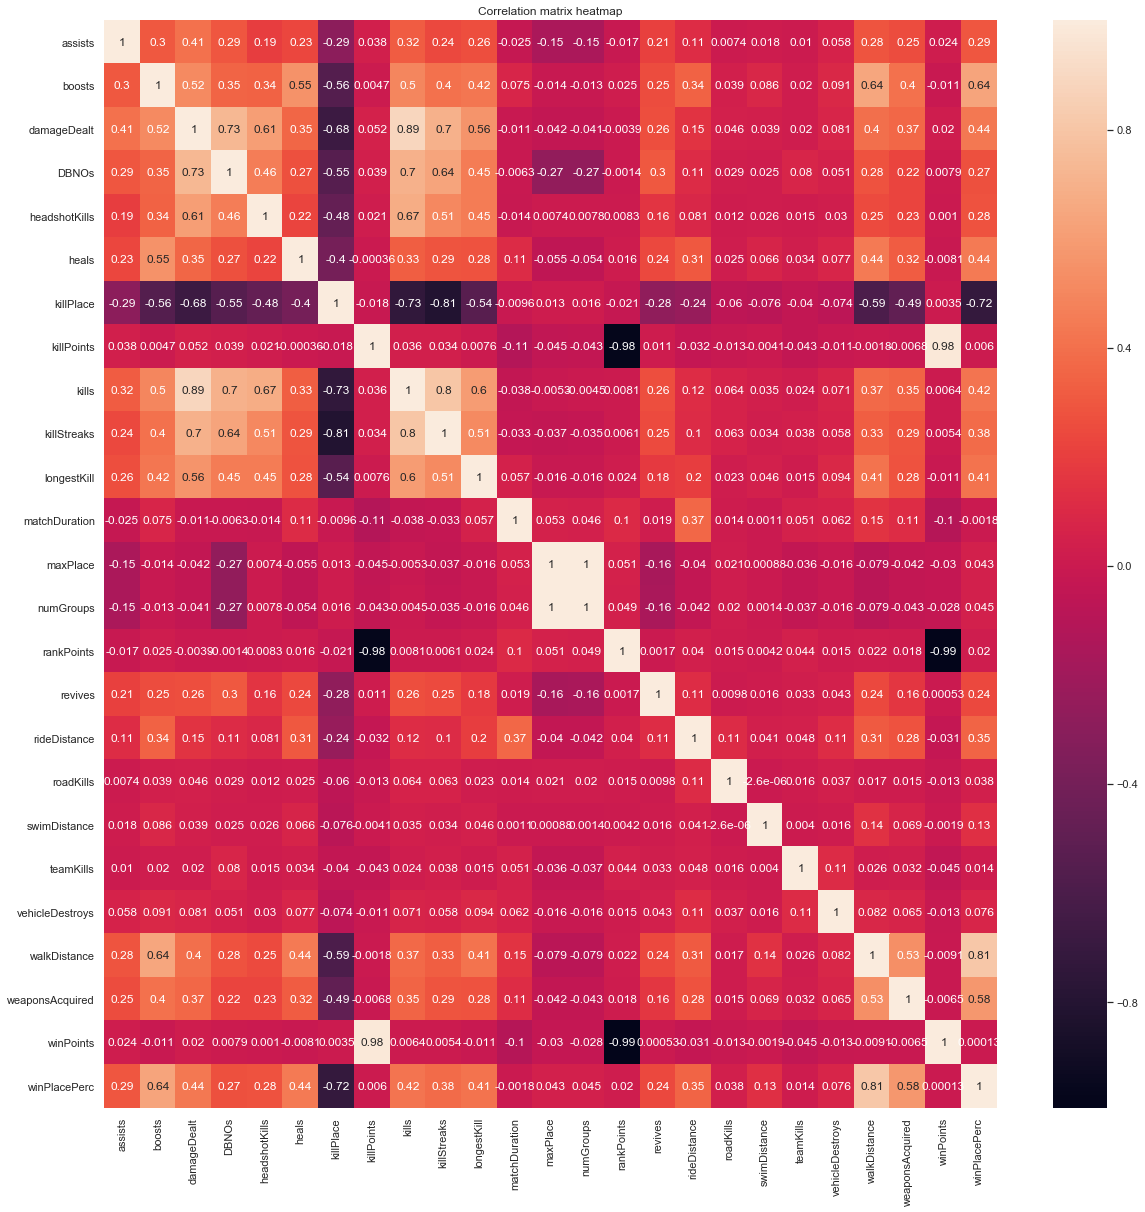

In [13]:
sns.set()
fig,ax=plt.subplots(figsize=(20,20))
ax.set_title('Correlation matrix heatmap')
sns.heatmap(df.corr(),annot=True)

### Drop unwanted columns

In [17]:
df.drop(['Id', 'groupId', 'matchId'],axis=1,inplace=True)

### Handle missing values

In [18]:
df.dropna(inplace=True)

### Handle categorial values

In [19]:
df=pd.get_dummies(df,drop_first=True)

### Split data into train and test sets

In [20]:
X=df.drop('winPlacePerc',axis=1)
y=df['winPlacePerc']
X_train, X_test, y_train, y_test = train_test_split(X, y) 

## A. Traditional ML Algorithms

### Build and evaluate various regression models with default hyperparameter values

In [18]:
models=[('lr',LinearRegression()),('lasso',Lasso()),('ridge',Ridge()),('bayridge',BayesianRidge()),('dtr',DecisionTreeRegressor()),('rfr',RandomForestRegressor()),('gbr',GradientBoostingRegressor()),('xgbr',XGBRegressor()),('svr',SVR())]
model_error={}
for (name,model) in models:
    model.fit(X_train,y_train)
    preds=model.predict(X_test)
    mae=mean_absolute_error(y_test,preds)
    model_error[f'{name}']=mae

C:\Users\aliba\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\aliba\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:00:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\aliba\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


### Select the best model (lowest MAE) 

In [20]:
model_error
#Random forest model has the lowest error.

{'lr': 0.08916253420287885,
 'lasso': 0.12134048044554305,
 'ridge': 0.08916668493460175,
 'bayridge': 0.08916816283048316,
 'dtr': 0.09187057894105655,
 'rfr': 0.06827263195576484,
 'gbr': 0.06932560776777391,
 'xgbr': 0.06877728724639222,
 'svr': 0.2670602329279455}

### Hyperparameter tunning and cross validation on selected model

In [21]:
#limited hyperparameter tunning due to memory limitation
parameters={'n_estimators':[10,40,70,100],'min_samples_leaf':[2,3,4],'max_features':[0.2,0.5,0.7,1]}
grid=GridSearchCV(RandomForestRegressor(),parameters,scoring='neg_mean_absolute_error',n_jobs=-1,cv=3)
grid.fit(X_train,y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_features': [0.2, 0.5, 0.7, 1

In [22]:
grid.best_params_

{'max_features': 0.7, 'min_samples_leaf': 2, 'n_estimators': 100}

### Make predictions and evaluate

In [23]:
preds=grid.predict(X_test)
mean_absolute_error(y_test,preds)

0.06411442221300379

## B. DeepLearning Algorithm

### Build the model

In [4]:
model=Sequential()
model.add(Dense(units=39,input_dim=39,activation='relu',kernel_initializer='normal'))
model.add(Dense(units=20,input_dim=20,activation='relu',kernel_initializer='normal'))
model.add(Dense(units=1,activation='linear',kernel_initializer='normal'))
model.compile(optimizer='adam',loss='mean_absolute_error',metrics=['mean_absolute_error'])
model.summary()

W1202 19:25:56.914490  2100 deprecation_wrapper.py:119] From C:\Users\aliba\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1202 19:25:56.939425  2100 deprecation_wrapper.py:119] From C:\Users\aliba\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1202 19:25:56.943413  2100 deprecation_wrapper.py:119] From C:\Users\aliba\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W1202 19:25:56.996300  2100 deprecation_wrapper.py:119] From C:\Users\aliba\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 39)                1560      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                800       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 2,381
Trainable params: 2,381
Non-trainable params: 0
_________________________________________________________________


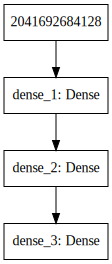

In [5]:
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [23]:
model.fit(X_train,y_train,epochs=10,batch_size=50)

Epoch 1/10
3335223/3335223 [==============================] - 66s 20us/step - loss: 0.0760 - mean_absolute_error: 0.0760
Epoch 2/10
3335223/3335223 [==============================] - 66s 20us/step - loss: 0.0698 - mean_absolute_error: 0.0698
Epoch 3/10
3335223/3335223 [==============================] - 65s 20us/step - loss: 0.0688 - mean_absolute_error: 0.0688
Epoch 4/10
3335223/3335223 [==============================] - 67s 20us/step - loss: 0.0680 - mean_absolute_error: 0.0680
Epoch 5/10
3335223/3335223 [==============================] - 66s 20us/step - loss: 0.0674 - mean_absolute_error: 0.0674
Epoch 6/10
3335223/3335223 [==============================] - 70s 21us/step - loss: 0.0669 - mean_absolute_error: 0.0669
Epoch 7/10
3335223/3335223 [==============================] - 66s 20us/step - loss: 0.0665 - mean_absolute_error: 0.0665
Epoch 8/10
3335223/3335223 [==============================] - 67s 20us/step - loss: 0.0662 - mean_absolute_error: 0.0662
Epoch 9/10
3335223/3335223 [====

In [24]:
# MAE on the test set
mae=model.evaluate(X_test,y_test)[1]
mae

1111742/1111742 [==============================] - 14s 13us/step


0.06371091073592286

### Conclusion

We obrserved that Random Forest Regressor had the best performance (0.068 MAE) among other traditional regressors. We were able to further decrease the MAE down to 0.0641 using hyper parameter tunning. <br>
Our deep learning model was also able to predict the targets with a slightly lower MAE i.e 0.637